    Copyright(c) 2022-
    Author: Chaitanya Tejaswi (github.com/CRTejaswi)    License: GPLv3.0+

# MicroMagnetic Simulation: Specifying System Geometries

Various geometries (such as cuboidal, spherical, vortex) can be approximated for system simulation. Everything is implemented as an approximation of cuboidal __cells__.

__Region, Mesh, Field (magnetization)__

- __region__ defines a physical cuboid (using 2 diagonal points), __mesh__ defines a discrete version of the __region__. A __field__ (such as $\vec{M}, \vec{m}, \vec{H}$) may be defined over this __mesh__. Additionally, the __field__ may be normalized using a saturation value (such as $M_{s}$), or by defining a norm that makes use of this saturation value. Once a __field__ is defined, we can operate on it (average, derivative, div, curl, ...).

- A __region__ may be decomposed into __subregions__ (such as Fe, Co, Ni, ...). We can define separate fields over each and simulate the system as a whole.

In [1]:
import discretisedfield as df
import micromagneticmodel as mm


# Region (defined using diagonal points)
p1,p2 = (0,-20e-9, 0), (100e-9, 20e-9, 10e-9)
region = df.Region(p1=p1, p2=p2)

# Mesh
cell = (10e-9, 10e-9, 10e-9)
mesh = df.Mesh(region=region, cell=cell)

# Field - const vector & spatially-varying vector fields
def _H(point):
    x,y,z = point
    if y > 0:
        return (1,0,0)
    else:
        return (-1,1,0)
    
Ms = 8e6
m1= df.Field(mesh, dim=3, value=(1,0,0), norm=Ms)
m2= df.Field(mesh, dim=3, value=_H, norm=Ms)

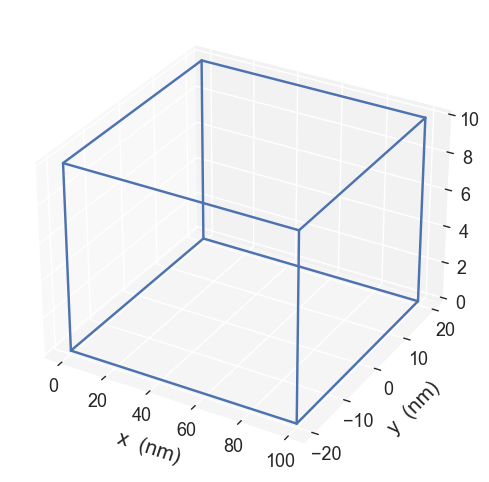

In [2]:
region.mpl()

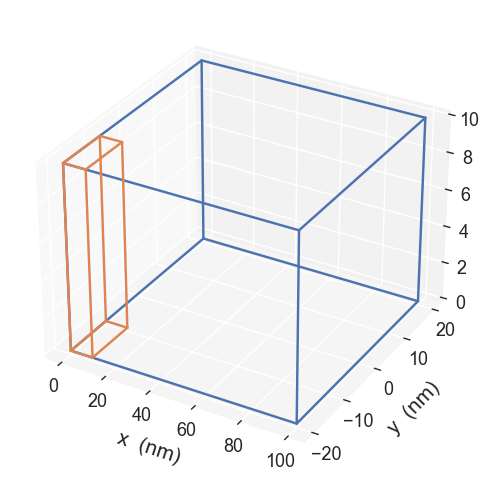

In [3]:
mesh.mpl()

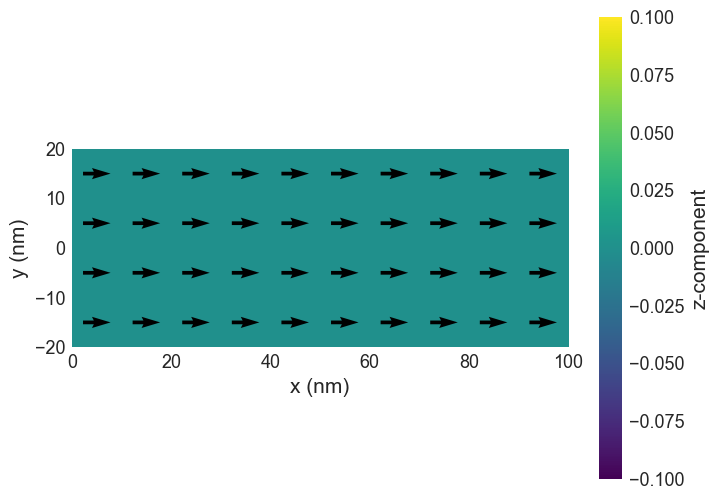

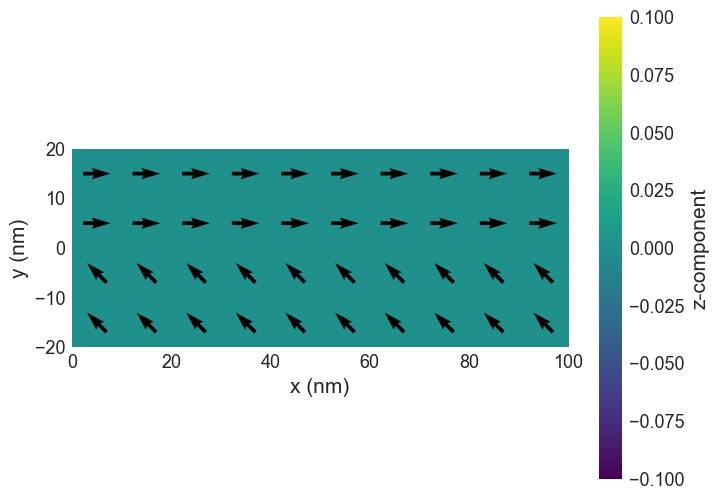

In [4]:
# Fixed & Variable fields
m1.plane('z').mpl()
m2.plane('z').mpl()

__Subregions__ 

- __subregions__ are a handy way to specify different materials/geometries. Fixed or Variable (__spatial/time varying__) fields may be specified for each of these regions.

We simulate a $20nm$ __region__ of two $10nm$ __subregions__, with a cell-size of $1nm$, with fixed & variable external fields.

The variable field is defined using: $\mathbf{H}(x, y, z) = (c^{2}x, 0, c)$
(where $c=10^{9}$ and the entire field is normalised with $H = 10^{6} \,\text{Am}^{-1}$)

The magnetisation is normalized, and is defined as a variable field itself.

We will visualise the system's initial state.

In [5]:
# Geometries
p1,p2 = (-10e-9, 0, 0), (10e-9, 1e-9, 1e-9)
cell = (1e-9, 1e-9, 1e-9)
subregions = {'Fe': df.Region(p1=(-10e-9, 0, 0), p2=(0, 1e-9, 1e-9)),
              'Co': df.Region(p1=(0, 0, 0), p2=(10e-9, 1e-9, 1e-9))}

# Magnetisation
import random
Ms = 8e5
def _m(pos):
    return [2*random.random()-1 for i in range(3)]

# System
system = mm.System()
system.m = df.Field(mesh, dim=3, value=_m, norm=Ms)
region = df.Region(p1=p1, p2=p2)
mesh = df.Mesh(region=region, cell=cell, subregions=subregions)

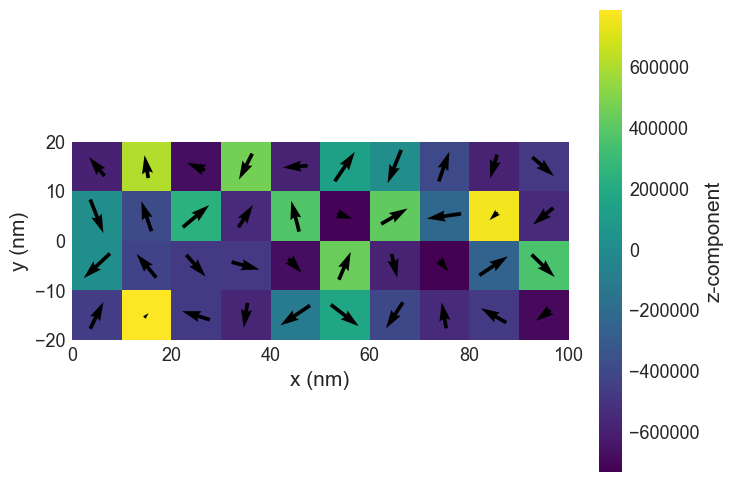

In [6]:
# Fixed field
H = {'Fe': (1e6, 0, 0), 'Co': (0, 0, -1e6)}
system.energy = mm.Zeeman(H=H)

# Initial State
system.m.plane('z').mpl()

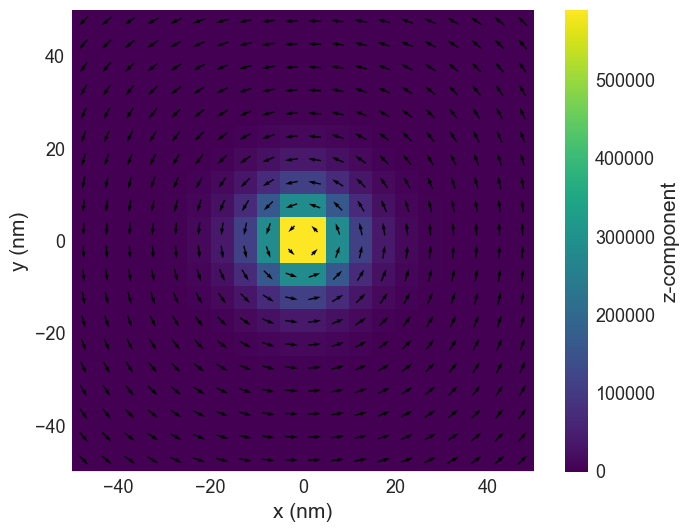

In [19]:
# Variable field
def _H(point):
    x, y, z = point
    c = 1e9
    return (c*c*x, 0, c)
H = df.Field(mesh, dim=3, value=_H, norm=1e6)
system.energy = mm.Zeeman(H=H)

# Initial State
system.m.plane('z').mpl()

__Saturation Magnetisation ($M_{s}$)__

Different geometries can be simulated by specifying a norm (ie, $M_{s}$).

- Spherical (radius, $r=50nm$)
- Disc (thickness: $t=50nm$, diameter $d=120nm$)
- Custom
- Vortex

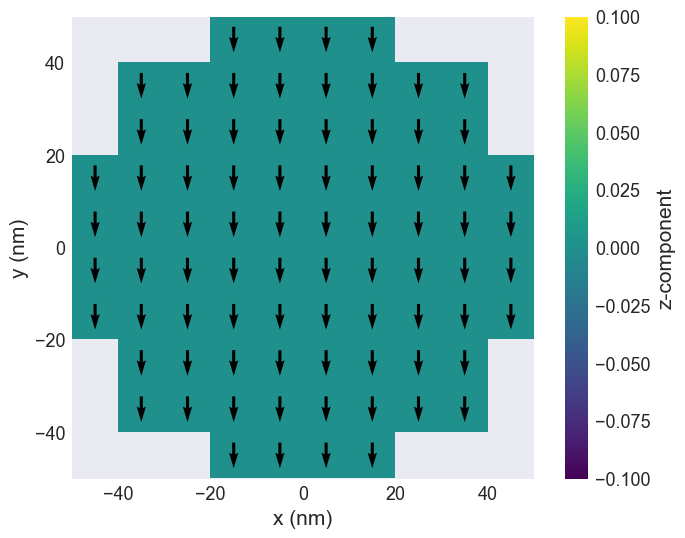

In [8]:
# Spherical Sample

# Region, Mesh
Ms = 8e6
r,n = 50e-9, (10,10,10)
region = df.Region(p1=(-r,-r,-r), p2=(r,r,r))
mesh   = df.Mesh(region=region, n=n)

# Norm using Ms
def _norm(point):
    x,y,z = point
    if x**2 + y**2 + z**2 < r**2:
        return Ms
    else:
        return 0
    
m = df.Field(mesh, dim=3, value=(0,-1,0), norm=_norm)
m.plane('z').mpl()

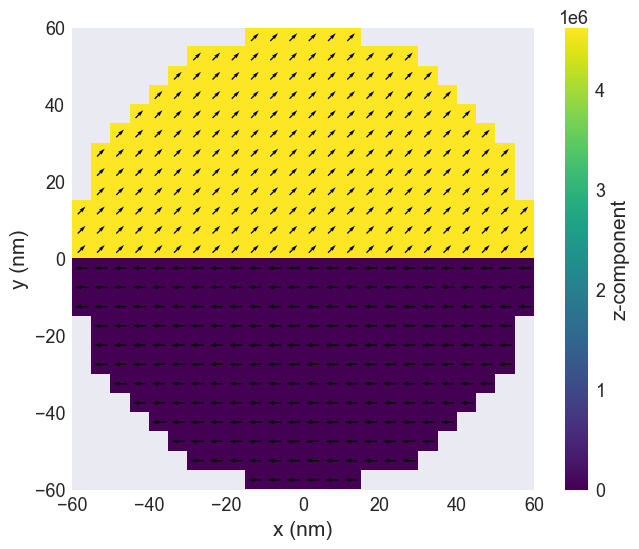

In [9]:
# Disk Sample

# Region, Mesh
Ms = 8e6
t,d = 10e-9, 120e-9
cell = (5e-9, 5e-9, 5e-9)
region = df.Region(p1=(-d/2, -d/2, -t/2), p2=(d/2, d/2, t/2))
mesh   = df.Mesh(region=region, cell=cell)

# Field - const vector & spatially-varying vector fields
def _norm(point):
    x,y,z = point
    if (x**2 + y**2) ** 0.5 < d/2:
        return Ms
    else:
        return 0
    
# Normalized magnetisation (m) as a variable vector field
def _m(point):
    x,y,z = point
    if y <= 0:
        return (-1,0,0)
    else:
        return (1,1,1)
    
m= df.Field(mesh, dim=3, value=_m, norm=_norm)
m.plane('z').mpl()

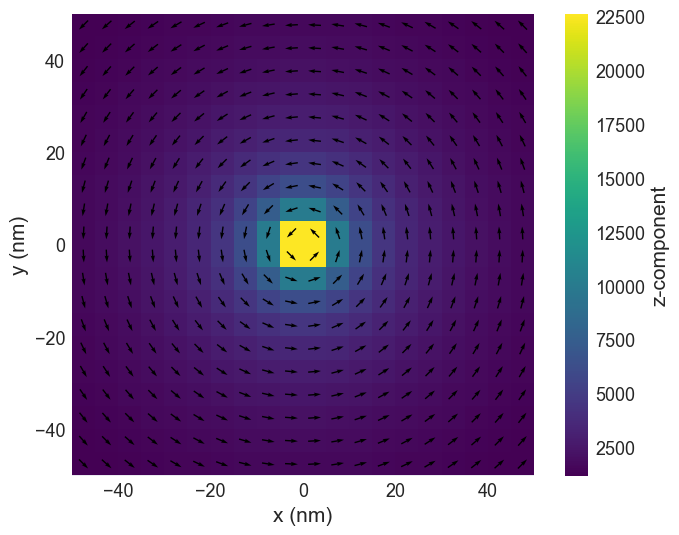

In [10]:
# Vortex field

# Geometry
L = 100e-9  # sample edge length (m)
thickness = 5e-9  # sample thickness (m)

# Material parameters
Ms = 8e5  # saturation magnetisation (A/m)
A = 13e-12  # exchange energy constant (J/m)

# Dynamics (LLG equation) parameters
gamma0 = mm.consts.gamma0  # gyromagnetic ratio (m/As)
alpha = 0.2  # Gilbert damping

system = mm.System(name='vortex_dynamics')
system.energy = mm.Exchange(A=A) + mm.Demag()
system.dynamics = mm.Precession(gamma0=gamma0) + mm.Damping(alpha=alpha)

# initial magnetisation state
def _m(point):
    x, y, z = point
    c = 1e9  # (1/m)
    return (-c*y, c*x, 0.1)

# Sample's centre is placed at origin
region = df.Region(p1=(-L/2, -L/2, -thickness/2), p2=(L/2, L/2, thickness/2))
mesh = df.Mesh(region=region, cell=(5e-9, 5e-9, 5e-9))
system.m = df.Field(mesh, dim=3, value=_m, norm=Ms)

# Initial State
system.m.plane('z').mpl()

__Simulating a system geometry__

We'll simulate the Vortex field after specifying the intial conditions.

Given the initial system state, we will:
1. Relax it (move core to centre) by minimising system energy
2. Apply an external magnetic field $H_{x}$ (Zeeman field along $+X$)
3. Remove the field, and save dynamics for $t=5ns, samples=500$
4. Visualise dynamics saved in previous step

Running OOMMF (DockerOOMMFRunner)[2022/11/10 02:55]... (1.6 s)


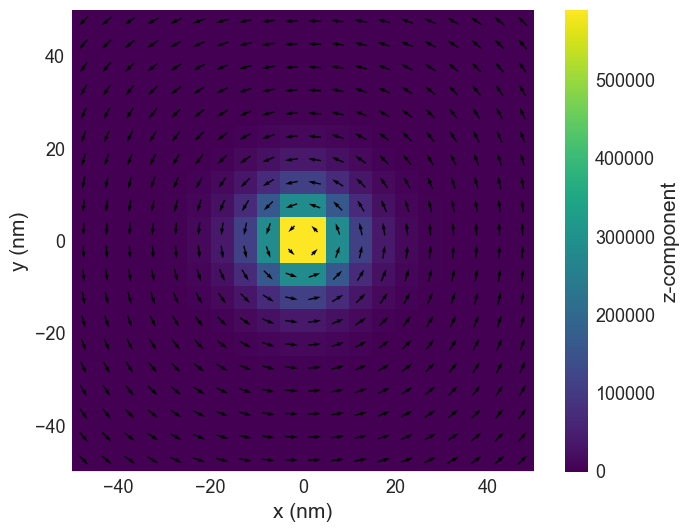

In [11]:
import oommfc as mc
docker_runner = mc.oommf.DockerOOMMFRunner(image='oommf/oommf')

# 1. Relax State
driver1 = mc.MinDriver()
driver1.drive(system)
system.m.plane('z').mpl()

Running OOMMF (DockerOOMMFRunner)[2022/11/10 02:55]... (1.8 s)


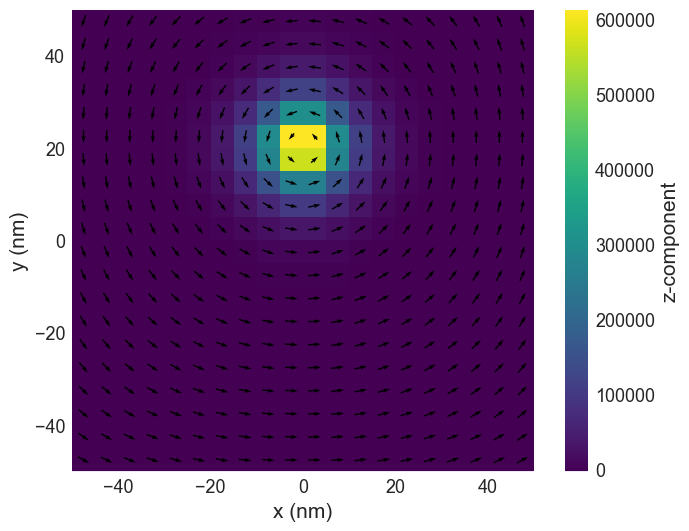

In [12]:
# 2. Apply External Field
H = (1e4, 0, 0)
system.energy += mm.Zeeman(H=H)
driver1.drive(system)
system.m.plane('z').mpl()

In [14]:
%%timeit -r1 -n1
# 3. Remove field; Observe system behaviour for 5ns 
system.energy.zeeman.H = (0,0,0)
driver2 = mc.TimeDriver()
driver2.drive(system, t=5e-9, n=500, runner=docker_runner)

Running OOMMF (DockerOOMMFRunner)[2022/11/10 02:58]... (19.7 s)
19.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [15]:
# 4. Plot a sequence of 500 samples
import micromagneticdata as md

data  = md.Data(system.name)
drive = data[-1]

@df.interact(nstep = drive.slider())
#@df.interact(nstep = drive.slider(continuous_update=False))
def systemplot(nstep):
    drive[nstep].plane('z').mpl()

interactive(children=(IntSlider(value=0, description='step', max=499), Output()), _dom_classes=('widget-intera…

In [16]:
data.info

,drive_number,date,time,driver,t,n
0,0,2022-11-09,21:16:14,MinDriver,NaN,NaN
1,1,2022-11-09,21:16:16,MinDriver,NaN,NaN
2,2,2022-11-09,21:16:19,TimeDriver,5.000000e-09,500.0
3,3,2022-11-09,21:23:57,MinDriver,NaN,NaN
4,4,2022-11-09,21:23:59,MinDriver,NaN,NaN
5,5,2022-11-09,21:24:04,MinDriver,NaN,NaN
6,6,2022-11-09,21:26:29,MinDriver,NaN,NaN
7,7,2022-11-09,21:26:31,MinDriver,NaN,NaN
8,8,2022-11-09,21:26:34,TimeDriver,5.000000e-09,500.0
9,9,2022-11-09,21:52:01,MinDriver,NaN,NaN
